### Neural Graph Revealers for recovering conditional independence graphs 

- We design a synthetic experiment to study the capability of `Neural Graph Revealers` to recover conditional independence graph represented by Gaussian graphical models.  
- The input data X is sampled from a multivariate Gaussian distribution where we define the underlying precision matrix.   
- Run `NGRs` to recover the underlying graph between features that should ideally match the CI graph.

In [1]:
import os, sys
# reloads modules automatically before entering the 
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
print(sys.prefix)
import warnings
warnings.filterwarnings('ignore')

import pickle

/anaconda/envs/ngm


### Setup the Gaussian graphical model
1. Initialize a graph type.
2. Get the precision matrix `theta` and corresponding samples `X` from a multivariate Gaussian distribution.
3. Get the partial correlations matrix `rho` and the graph `G`.

In [2]:
import numpy as np
import pandas as pd

# Local imports
from ngr.utils import ggm
from ngr.utils import data_processing as dp
# from uGLAD.utils.metrics import reportMetrics

# Xb = samples batch, trueTheta = corresponding true precision matrices
Xb, true_theta = ggm.get_data(
    num_nodes=10, 
    typeG='CHAIN', 
    sparsity=[0.2, 0.2], # Not used for chain graph
    num_samples=5000, 
    batch_size=1,
    eig_offset=0.1, # 0.5 #0.1, 
    w_min=0.5,
    w_max=1
)
X, true_theta =Xb[0], true_theta[0]
# set the column names for X
X = pd.DataFrame(X, columns=['n'+str(i) for i in range(X.shape[1])])
rho = ggm.get_partial_correlations(true_theta)
print(f'partial correlations: {rho.shape}, Samples {X.shape}')
G, image_G, graph_edge_list = ggm.graph_from_partial_correlations(rho, X.columns)

partial correlations: (10, 10), Samples (5000, 10)
Sparsity 1 using threshold 0.0


In [3]:
Gv = dp.get_interactive_graph(G, 'GGM Chain graph', node_PREFIX=None)
Gv.show('viz_ggm.html')

In [4]:
X

,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9
0,0.676036,0.451816,0.080748,1.058577,1.339929,-1.969158,1.860923,-0.345677,-0.552015,-0.337539
1,1.282480,-0.983644,-1.833450,-2.505785,-1.577882,-0.219246,-0.428026,-0.897443,-1.275652,1.009761
2,0.801756,-1.648733,-1.114228,-0.439631,-0.497442,0.710978,-0.237927,0.929126,0.458265,-0.216546
3,0.006248,0.190536,0.803324,0.357295,-0.278333,1.036790,-1.470982,-0.291435,-0.571212,-1.275389
4,0.318701,-0.538353,-0.462914,-0.780909,-0.493407,-0.310135,1.109550,0.081895,1.820346,-0.843485
...,...,...,...,...,...,...,...,...,...,...
4995,1.321960,0.891799,1.368585,0.399934,1.946923,-1.456880,1.479960,1.400734,0.527720,-0.095899
4996,0.898517,1.400449,0.951690,0.275007,-0.175280,1.384342,-0.025058,0.861005,0.045303,0.370613
4997,-0.624213,1.230318,1.646913,-0.790606,-0.675766,0.603967,-0.367855,-1.341452,1.799987,0.160499
4998,0.146054,1.556886,0.413867,0.361086,-0.673177,-0.002407,-0.159083,-0.275596,-0.224464,0.522285


### Neural graph revealer

For faster runtimes, set USE_CUDA=True

In [136]:
model_NGR = ngr.recover_graph(
    X, lambd=1e2,
    hidden_dim=100,
    epochs=50000, 
    lr=0.0005, #0.0005,
    norm_type='min_max',
    k_fold=1,
    structure_penalty='hadamard',
    VERBOSE=True, 
    BATCH_SIZE=None#5000, #1000
) 

Means of selected features (n0   -0.020526
n1   -0.005040
n2    0.004501
n3    0.009718
n4   -0.003428
n5    0.010776
n6    0.005219
n7    0.003182
n8    0.020203
n9    0.007042
dtype: float64, 10)
Normalizing the data: min_max
: Processing the input table for basic compatibility check
: The input table has sample 5000 and features 10
: Total zero samples dropped 0
: Single value columns dropped: total 0, columns []
: The processed table has sample 5000 and features 10
: Total time to process the table 0.009 secs
Fold num 0
Initializing the NGM model

Fold 0: epoch:0/50000
Train: loss=1032.5936279296875, reg=0.2635793387889862, struct=10.3233003616333
Test: loss=1032.5927734375, reg=0.2627401053905487, struct=10.3233003616333

Fold 0: epoch:5000/50000
Train: loss=471.111328125, reg=0.01933593675494194, struct=4.7109198570251465
Test: loss=471.11090087890625, reg=0.01893388107419014, struct=4.7109198570251465

Fold 0: epoch:10000/50000
Train: loss=471.09674072265625, reg=0.0190960355103

In [9]:
import pandas as pd
import ngr.main as ngr
import ngr.utils.data_processing as dp

# Learning the NGR model, works with no log scaling forward NGM
# model_NGR = ngr.recover_graph(
#     X, lambd=1e2,
#     hidden_dim=100,
#     epochs=50000, 
#     lr=0.0005, #0.0005,
#     norm_type='min_max',
#     k_fold=1,
#     structure_penalty='hadamard',
#     VERBOSE=True, 
#     BATCH_SIZE=None#5000, #1000
# ) 
model_NGR = ngr.recover_graph(
    X, lambd=1e0,
    hidden_dim=100,
    epochs=2000, 
    lr=0.0005, #0.0005,
    norm_type='min_max',
    k_fold=1,
    structure_penalty='hadamard',
    VERBOSE=True, 
    BATCH_SIZE=None#5000, #1000
) 
# NOTE 
# Divide into batches
# Stop training when train & test loss are low and the values are comparable. 
# Focus on structure loss, it becomes constant after certain iterations and then focus on regression starts... 
# Maybe adjust lambda to fit the regression first and then narrow down the structure?

Means of selected features (n0   -0.005497
n1    0.000595
n2   -0.005681
n3    0.021511
n4    0.013286
n5   -0.017079
n6    0.014729
n7    0.006687
n8   -0.018608
n9    0.011635
dtype: float64, 10)
Normalizing the data: min_max
: Processing the input table for basic compatibility check
: The input table has sample 5000 and features 10
: Total zero samples dropped 0
: Single value columns dropped: total 0, columns []
: The processed table has sample 5000 and features 10
: Total time to process the table 0.01 secs
Fold num 0
Initializing the NGM model
Struct loss: diag 0.003540955251082778, prod_w sparsity 0.031606562435626984
Struct loss: diag 0.003540955251082778, prod_w sparsity 0.031606562435626984

Fold 0: epoch:0/2000
Train: loss=-8.75784683227539, reg=0.3399030566215515, struct=-9.097749710083008
Test: loss=-8.758260726928711, reg=0.3394891917705536, struct=-9.097749710083008
Struct loss: diag 0.003488127375021577, prod_w sparsity 0.031606629490852356
Struct loss: diag 0.003488127

## Make sure that the diagonals are going to zero
### Why is the structure loss becoming constant?

In [10]:
import networkx as nx
# Plot the graph
def adjust_graph_sparsity(G_in, sparsity=1, roundOFF=4):
    G = nx.Graph() # G_out 
    names = np.array(G_in.nodes())
    G.add_nodes_from(names)
    rho = np.array(nx.adjacency_matrix(G_in).todense())
    D = rho.shape[-1]
    
    # determining the threshold to maintain the sparsity level of the graph
    def upper_tri_indexing(A):
        m = A.shape[0]
        r,c = np.triu_indices(m,1)
        return A[r,c]

    rho_upper = upper_tri_indexing(np.abs(rho))
    num_non_zeros = int(sparsity*len(rho_upper))
    rho_upper.sort()
    th = rho_upper[-num_non_zeros]
    print(f'Sparsity {sparsity} using threshold {th}')
    th_pos, th_neg = th, -1*th

    for i in range(D):
        for j in range(i+1, D):
            if rho[i,j] > th_pos:
                G.add_edge(names[i], names[j], color='green', weight=round(rho[i,j], roundOFF), label='+')
            elif rho[i,j] < th_neg:
                G.add_edge(names[i], names[j], color='red', weight=round(rho[i,j], roundOFF), label='-')
    return G

def get_graph_NGR(model_NGR, sparsity=1):
    model, scaler, feature_means = model_NGR
    # Get the dependency matrix
    prod_W = dp.t2np(ngr.product_weights_MLP(model))
    print(prod_W)
    # Get the adjacency matrix (symmetric)
    adj = (prod_W + np.transpose(prod_W))/2.0
    # adj=prod_W
    G = nx.from_numpy_matrix(adj)
    # add node names
    mapping = {i:f for i, f in enumerate(feature_means.index)}
    G = nx.relabel_nodes(G, mapping)
    # adjust sparsity
    G = adjust_graph_sparsity(G, sparsity=sparsity)
    return G
G_ngr = get_graph_NGR(model_NGR)
Gv_ngr = dp.get_interactive_graph(G_ngr, 'NGR graph', node_PREFIX=None)
Gv_ngr.show('viz_ngr.html')

[[7.2216272e-04 2.5422162e-01 4.2710108e-01 4.4704202e-01 1.5675829e-01
  3.3613595e-01 2.8792441e-01 2.5691015e-01 1.9214347e-01 4.7929746e-01]
 [4.4015062e-01 1.0273987e-03 2.7855137e-01 2.9872066e-01 1.4140345e-01
  2.7218908e-01 2.7479473e-01 2.7166140e-01 2.8156710e-01 5.6282109e-01]
 [6.2001008e-01 2.7949646e-01 9.3720650e-04 2.3824728e-01 1.5060374e-01
  2.4606182e-01 2.1821350e-01 2.3347273e-01 1.7536242e-01 5.1439285e-01]
 [6.3036740e-01 1.8929704e-01 1.5711473e-01 6.5423711e-04 1.1476569e-01
  2.4880637e-01 2.9561535e-01 2.7208814e-01 2.6946598e-01 4.8271108e-01]
 [5.3012085e-01 2.2781140e-01 2.5497866e-01 2.6103505e-01 1.5097018e-03
  2.9560909e-01 2.2704986e-01 3.3679557e-01 2.5540194e-01 4.6510258e-01]
 [7.4491531e-01 2.6846564e-01 2.8058618e-01 2.6832122e-01 1.5104659e-01
  9.5947646e-04 2.1605282e-01 2.2778426e-01 2.7882650e-01 1.5224263e-01]
 [6.2346429e-01 2.8152895e-01 3.3924341e-01 2.7345008e-01 2.1084668e-01
  2.0681292e-01 1.4806001e-03 1.6174881e-01 2.0639123e-01 

### Comparison 

In [11]:
# Comparing with true precision matrix
from ngr.utils.metrics import graph_compare_metrics

true_adj = np.array(nx.adjacency_matrix(G).todense())
ngr_adj = np.array(nx.adjacency_matrix(G_ngr).todense())
compare_results = graph_compare_metrics(
    np.abs(true_adj), 
    np.abs(ngr_adj) # Compare with sparsity=1
)
compare_results

{'FDR': 0.7954545454545454,
 'TPR': 1.0,
 'FPR': 0.9722222222222222,
 'SHD': 35,
 'nnzTrue': 9,
 'nnzPred': 44,
 'precision': 0.20454545454545456,
 'recall': 1.0,
 'Fbeta': 0.33962264150943394,
 'aupr': 0.15024937526739612,
 'auc': 0.2808641975308642}

In [216]:
true_adj, ngr_adj

(array([[ 0.     ,  0.41382,  0.     ,  0.     ,  0.     ,  0.     ,
          0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.41382,  0.     ,  0.54164,  0.     ,  0.     ,  0.     ,
          0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.54164,  0.     ,  0.48025,  0.     ,  0.     ,
          0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.48025,  0.     , -0.56666,  0.     ,
          0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.     , -0.56666,  0.     ,  0.42316,
          0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.     ,  0.     ,  0.42316,  0.     ,
          0.45974,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.45974,
          0.     , -0.4629 ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         -0.4629 ,  0.     ,  0.49318,  0.     ],
        [ 0.     ,  0.     ,  0.     ,  0.     ,

In [217]:
true_theta

array([[ 1.6082563 , -0.66553397,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.66553397,  1.6082563 , -0.87110392,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.87110392,  1.6082563 , -0.77236818,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.77236818,  1.6082563 ,  0.91133803,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.91133803,  1.6082563 ,
        -0.68054659,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.68054659,
         1.6082563 , -0.73937534,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.73937534,  1.6082563 ,  0.74445568

### Params to vary  
USE FROBENIUS NORM  
ADD soft-symmetry term in draft  
1. Different lambda for structure loss l1 & diag  
2. Neural network num layers, dimensions, initializations  
3. learning rate, early stopping  
4. Try DAG data instead of GGM. Add the GGM results as under investigation  

#### GGM
Can be shown analytically 

Features dropped from graph: set()
target=n5, source=n4
target=n5, source=n6


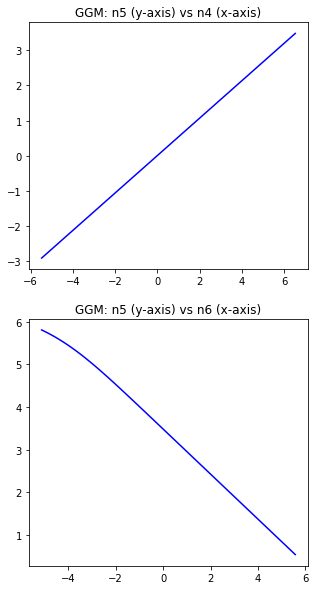

In [86]:
# Local imports
from ngm.utils import ggm

# Define the mean and cov of the multivariate Gaussian
data_min_ = X.min(axis=0)
data_max_ = X.max(axis=0)
_scaler = [data_min_, data_max_]
D = true_theta.shape[0]
mean = pd.Series(np.zeros(D), index=X.columns)
cov=np.linalg.pinv(true_theta)

# Analyse the feature dependency functions
ggm.analyse_feature(feature_of_interest, [mean, cov, _scaler], G, Xi=mean)

#### NGM

Features dropped from graph: set()
target=n5, source=n4
target=n5, source=n6


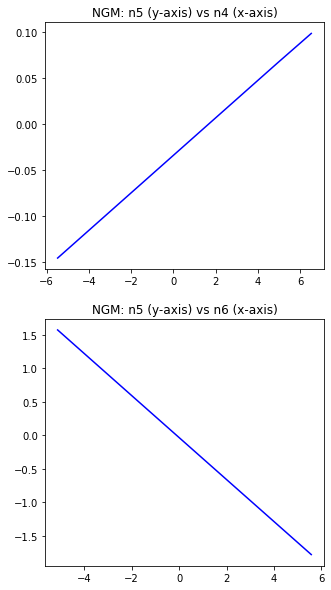

In [87]:
# Analyse the distribution details of the feature of interest
ngm.analyse_feature(feature_of_interest, model_NGM, G, dp.series2df(mean))

### NGM: Sampling

In [ ]:
import ngm.main as ngm

Xs = ngm.sampling(model_NGM, G, num_samples=4000, max_infer_itr=2)
Xs = Xs[X.columns]

### Run CI graph recovery algorithms
1. uGLAD
2. BCD

In [68]:
# uGLAD
from ngm.utils.uGLAD import main as uG
from ngm.utils.metrics import reportMetrics

# Initialize the model
model_uGLAD = uG.uGLAD_GL()  

Xs = Xs[X.columns]
# Fit to the data
model_uGLAD.fit(
    Xs,
    centered=False,
    epochs=2000,
    lr=0.001,
    INIT_DIAG=0,
    L=5,
    verbose=True, 
    k_fold=0,  # Direct mode
    mode='direct'
)  

# Comparing with true precision matrix
compare_theta_uGLAD = reportMetrics(
        true_theta, 
        model_uGLAD.precision_
    )
print(f'uGLAD: {compare_theta_uGLAD}')

Running uGLAD
Processing the input table for basic compatibility check
: Processing the input table for basic compatibility check
: The input table has sample 4000 and features 10
: Total zero samples dropped 0
: Single value columns dropped: total 0, columns []
Input covariance matrix: The condition number 1.5572058852566435 and min eig 0.006871181005512089 max eig 0.010699843500447085
: Duplicates dropped: total 0, columns []
: Low Variance columns dropped: min variance 0.0,        total 0, columns []
Processed covariance matrix: The condition number 1.5572058852566435 and min eig 0.006871181005512089 max eig 0.010699843500447085
: The processed table has sample 4000 and features 10
: Total time to process the table 0.852 secs
Direct Mode
epoch:0/2000 loss:-12.358485221862793
epoch:200/2000 loss:-15.940261840820312
epoch:400/2000 loss:-20.333969116210938
epoch:600/2000 loss:-25.18743133544922
epoch:800/2000 loss:-37.673797607421875
epoch:1000/2000 loss:-37.6756591796875
epoch:1200/20

In [82]:
def viz_graph_from_precision(theta):
    rho = ggm.get_partial_correlations(theta)
    Gr, _, _ = ggm.graph_from_partial_correlations(
        rho, 
        Xs.columns,
        sparsity=0.3
    )
    Gv = dp.get_interactive_graph(Gr, 'CI graph recovered from NGM samples', node_PREFIX=None)
    return Gv
    

In [83]:
Gv = viz_graph_from_precision(model_uGLAD.precision_)
Gv.show('viz_ggm_from_ngm_samples.html')

Sparsity 0.3 using threshold 0.05290000024270138
